In [48]:
from pycaret.classification import *
from pycaret.datasets import get_data
from sklearn import metrics
from sklearn.model_selection import train_test_split
from utils import cost_function_amount

import pandas as pd
import numpy as np
import mlflow
import seaborn as sns
import xgboost

In [2]:
dataset = pd.read_csv('PS_20174392719_1491204439457_log.csv')

In [3]:
dataset.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
dataset.shape

(6362620, 11)

In [5]:
dataset['type'].value_counts()

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64

<AxesSubplot:>

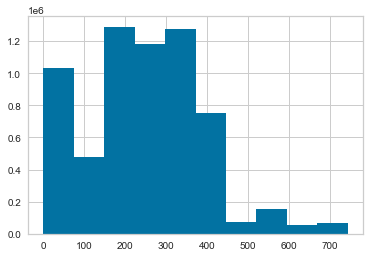

In [6]:
dataset['step'].hist()

In [7]:
dataset['nameOrig'].map(lambda x: x[0]).value_counts()

C    6362620
Name: nameOrig, dtype: int64

In [8]:
dataset['nameDest'].map(lambda x: x[0]).value_counts()

C    4211125
M    2151495
Name: nameDest, dtype: int64

In [9]:
dataset['nameDest_know'] = dataset['nameDest'].map(lambda x: 1 if x[0] == 'C' else 0) 

In [10]:
dataset.type.value_counts()

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64

<AxesSubplot:>

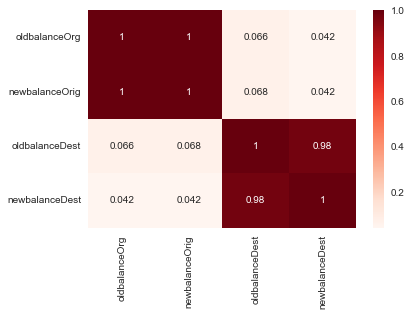

In [11]:
sns.heatmap(dataset[['oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']].corr(), annot=True, cmap='Reds')

In [12]:
x_columns = [
    col for col in dataset.columns if col not in [
        'nameOrig', 'nameDest', 'isFlaggedFraud', 'oldbalanceOrg', 'oldbalanceDest']]

In [13]:
x_columns

['step',
 'type',
 'amount',
 'newbalanceOrig',
 'newbalanceDest',
 'isFraud',
 'nameDest_know']

In [14]:
data = dataset[x_columns].copy()

In [15]:
data.head()

,step,type,amount,newbalanceOrig,newbalanceDest,isFraud,nameDest_know
0,1,PAYMENT,9839.64,160296.36,0.0,0,0
1,1,PAYMENT,1864.28,19384.72,0.0,0,0
2,1,TRANSFER,181.00,0.00,0.0,1,1
3,1,CASH_OUT,181.00,0.00,0.0,1,1
4,1,PAYMENT,11668.14,29885.86,0.0,0,0


In [16]:
X_train, X_test, y_train, y_test = train_test_split(data[x_columns], data['isFraud'],
                                                    stratify=data['isFraud'], 
                                                    test_size=0.20, random_state=42)

In [17]:
X_train['isFraud'] = y_train
X_test['isFraud'] = y_test

In [18]:
X_train.isFraud.value_counts()

0    5083526
1       6570
Name: isFraud, dtype: int64

In [19]:
X_train.isFraud.value_counts() [1] / X_train.isFraud.value_counts() [0]

0.0012924100319345274

In [20]:
X_test.isFraud.value_counts()

0    1270881
1       1643
Name: isFraud, dtype: int64

In [21]:
X_train_sample = pd.concat([
    X_train[X_train.isFraud == 1],
    X_train[X_train.isFraud == 0].sample(n=1000000, random_state=42)
])

In [22]:
X_train_sample.isFraud.value_counts() 

0    1000000
1       6570
Name: isFraud, dtype: int64

In [23]:
X_train_sample.isFraud.value_counts() [1] / X_train_sample.isFraud.value_counts() [0]

0.00657

In [24]:
clf = setup(
    X_train_sample,
    target='isFraud',
    categorical_features=['type'],
    numeric_features=['step', 'amount', 'newbalanceOrig', 'newbalanceDest', 'nameDest_know'],
    log_experiment = True,
    experiment_name = 'fraude',
    silent=True)

,Description,Value
0,session_id,7363
1,Target,isFraud
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(1006570, 7)"
5,Missing Values,False
6,Numeric Features,5
7,Categorical Features,1
8,Ordinal Features,False
9,High Cardinality Features,False


In [25]:
add_metric('prauc', 'PR AUC', metrics.average_precision_score, greater_is_better = True) 

Name                                                            PR AUC
Display Name                                                    PR AUC
Score Function       <function average_precision_score at 0x7fb54ed...
Scorer                            make_scorer(average_precision_score)
Target                                                            pred
Args                                                                {}
Greater is Better                                                 True
Multiclass                                                        True
Custom                                                            True
Name: prauc, dtype: object

In [26]:
best_models = compare_models(['lr', 'lightgbm', 'xgboost'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,PR AUC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.9982,0.9890,0.7570,0.9655,0.8485,0.8476,0.8540,0.7324,20.6160
lightgbm,Light Gradient Boosting Machine,0.9958,0.9383,0.6613,0.7864,0.7030,0.7011,0.7113,0.5209,1.6150
lr,Logistic Regression,0.9912,0.5853,0.1504,0.2330,0.1828,0.1786,0.1830,0.0409,1.4760


# xgboost 

In [27]:
xgboost_model = create_model('xgboost',fold=10)
tuned_xgboost = tune_model(xgboost_model, optimize = 'prauc',fold=10)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,PR AUC
Fold,,,,,,,,
0,0.9977,0.9874,0.7739,0.8578,0.8137,0.8126,0.8136,0.6654
1,0.9978,0.9840,0.7696,0.8741,0.8185,0.8174,0.8191,0.6742
2,0.9978,0.9790,0.7696,0.8806,0.8213,0.8203,0.8221,0.6792
3,0.9976,0.9839,0.7609,0.8621,0.8083,0.8071,0.8087,0.6575
4,0.9977,0.9860,0.7543,0.8741,0.8098,0.8086,0.8109,0.6609
5,0.9977,0.9879,0.7739,0.8599,0.8146,0.8135,0.8146,0.6670
6,0.9981,0.9839,0.7957,0.8971,0.8433,0.8424,0.8439,0.7151
7,0.9978,0.9854,0.7739,0.8725,0.8203,0.8192,0.8207,0.6768
8,0.9977,0.9840,0.7848,0.8494,0.8158,0.8147,0.8153,0.6680


In [45]:
preds_xgboost = predict_model(tuned_xgboost, data = X_test, raw_score=True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,PR AUC
0,Extreme Gradient Boosting,0.9990,0.9844,0.7888,0.5804,0.6687,0.6682,0.6761,0.4581


In [49]:
cost_function_amount(preds_xgboost.isFraud.values, preds_xgboost.Score_1.values, preds_xgboost.amount.values)

45042665067.918564

# lightgbm

In [35]:
lightgbm_model = create_model('lightgbm',fold=10)
tuned_lightgbm = tune_model(lightgbm_model, optimize = 'prauc',fold=10)    

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,PR AUC
Fold,,,,,,,,
0,0.9977,0.9901,0.6804,0.9631,0.7975,0.7964,0.8085,0.6574
1,0.9978,0.9875,0.7087,0.9422,0.8089,0.8079,0.8162,0.6696
2,0.9978,0.9855,0.7109,0.9370,0.8084,0.8073,0.8151,0.6679
3,0.9978,0.9869,0.7043,0.9419,0.8060,0.8049,0.8135,0.6653
4,0.9978,0.9898,0.6891,0.9577,0.8015,0.8004,0.8114,0.6620
5,0.9979,0.9901,0.7130,0.9480,0.8139,0.8128,0.8212,0.6778
6,0.9981,0.9867,0.7304,0.9739,0.8348,0.8339,0.8426,0.7131
7,0.9980,0.9858,0.7152,0.9705,0.8235,0.8225,0.8323,0.6960
8,0.9978,0.9870,0.7152,0.9400,0.8123,0.8113,0.8190,0.6742


In [43]:
preds_lightgbm = predict_model(tuned_lightgbm, data = X_test, raw_score=True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,PR AUC
0,Light Gradient Boosting Machine,0.9994,0.9876,0.7103,0.8207,0.7615,0.7612,0.7632,0.5833


In [44]:
cost_function_amount(preds_lightgbm.isFraud.values, preds_lightgbm.Score_1.values, preds_lightgbm.amount.values)

45072820220.81244

# Linel regresion

In [39]:
lr_model = create_model('lr',fold=10)
tuned_lr = tune_model(lr_model, optimize = 'prauc',fold=10)   

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,PR AUC
Fold,,,,,,,,
0,0.9908,0.5724,0.1217,0.1854,0.1470,0.1425,0.1457,0.0283
1,0.9913,0.5889,0.1587,0.2425,0.1919,0.1877,0.1919,0.0440
2,0.9914,0.5705,0.1630,0.2525,0.1982,0.1940,0.1987,0.0466
3,0.9912,0.5863,0.1500,0.2315,0.1821,0.1778,0.1821,0.0403
4,0.9913,0.6013,0.1630,0.2500,0.1974,0.1932,0.1977,0.0462
5,0.9912,0.5906,0.1674,0.2444,0.1987,0.1944,0.1980,0.0464
6,0.9913,0.5949,0.1500,0.2379,0.1840,0.1799,0.1847,0.0412
7,0.9912,0.5815,0.1283,0.2107,0.1595,0.1553,0.1601,0.0327
8,0.9911,0.5999,0.1413,0.2174,0.1713,0.1670,0.1709,0.0363


In [40]:
preds_lr = predict_model(tuned_lr, data = X_test, raw_score=True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,PR AUC
0,Logistic Regression,0.9956,0.6003,0.1491,0.0555,0.0809,0.0792,0.0891,0.0094


In [42]:
cost_function_amount(preds_lr.isFraud.values, preds_lr.Score_1.values, preds_lr.amount.values)

42509612743.89531

El mejor modelo que es xgboost y las ganancias son mucho mejores que lineal regresión y lightgbm